# Logistic model

## Imports

In [ ]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
import seaborn as sns


# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [2]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)


Unnamed: 0                        species  median_counts  mean_counts  1  \
0           0  Prevotella sp. Smarlab 121567          412.0   415.156682  0   
1           1     Parabacteroides distasonis          205.5   206.709677  0   
2           3   Barnesiella intestinihominis          142.0   145.419355  0   
3           4        Barnesiella viscericola          125.5   137.092166  0   
4           2      Lactobacillus taiwanensis          123.5   174.769585  0   

     8    9  10   15   17  ...  1001  1004  1010  1016  1022  1028  1029  \
0    0    0   2   10   18  ...   220   248   252   286   346   293   277   
1    0    0   2   41  145  ...   136   157   206   133   177   105   163   
2    0    0   1   19   58  ...   158   145   184   131   145   154   119   
3    1    0   1  112  195  ...    66    85   134    96   126   121    92   
4  422  309   0   48   15  ...    36   162   282   174   100   306   517   

   1035  1039  1044  
0   190   222   364  
1   147   208   222  
2   130    71   161  
3    71    72   147  
4   193   513   175  

[5 rows x 221 columns]

In [3]:
# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(10) # -> As we can see we have the count per day of the selected species in each mouse

day  mouse_1  mouse_2  mouse_3  mouse_4  mouse_5  mouse_6  mouse_7  \
0    0        0        1        0        0        0        0        0   
1    1        0        0        0        0        0        0        0   
2    2        0        1        1        0        0        0        0   
3    3        0        0        0        0        2        0        0   
4    4        0        0        0        0        0        0        0   
5    5        0        0        0        0        0        0        0   
6    6        0        0        0        0        0        0        0   
7    7        0        0        0        0        0        0        0   
8    8        0        0        0        0        0        0        0   
9    9        0        0        9        0        1       60        0   

   mouse_8   mean        std  
0        2  0.375   0.744024  
1        1  0.125   0.353553  
2        2  0.500   0.755929  
3        0  0.250   0.707107  
4        0  0.000   0.000000  
5        0  0.000   0.000000  
6        0  0.000   0.000000  
7        0  0.000   0.000000  
8        7  0.875   2.474874  
9        0  8.750  20.940392

## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [23]:
mice_diss = []

for mouse in range(1,9): 
    file_path = f"Data/dissimilarities/dissimilarity_{mouse}.csv"
    
    if os.path.exists(file_path):  
        # Load existing data, prevents from computing dissimilarity each time
        print(f"Loading existing data for Mouse {mouse}...")
        df = pd.read_csv(file_path, index_col=0)  
    else:
        df = mi.get_dissimilarities(mouse, write = True)
    mice_diss.append(df)

Loading existing data for Mouse 1...
Loading existing data for Mouse 2...
Loading existing data for Mouse 3...
Loading existing data for Mouse 4...
Loading existing data for Mouse 5...
Loading existing data for Mouse 6...
Loading existing data for Mouse 7...
Loading existing data for Mouse 8...


In [ ]:
#mice_diss[0].head()

1         2         3         4  \
Prevotella sp. Smarlab 121567  0.152198  0.171746  0.062899  0.094635   
Parabacteroides distasonis     0.063016  0.084766  0.051827  0.052748   
Barnesiella intestinihominis   0.137988  0.090815  0.087523  0.109374   
Barnesiella viscericola        0.160086  0.079281  0.060972  0.120502   
Lactobacillus taiwanensis      0.378027  0.294579  0.240163  0.315811   

                                      5         6         7         8  \
Prevotella sp. Smarlab 121567  0.111559  0.100248  0.159679  0.158560   
Parabacteroides distasonis     0.085593  0.070336  0.085282  0.074986   
Barnesiella intestinihominis   0.123000  0.083900  0.144142  0.103052   
Barnesiella viscericola        0.157528  0.097143  0.143658  0.096437   
Lactobacillus taiwanensis      0.377685  0.302834  0.428027  0.476685   

                                      9        10  ...      1027  1028  \
Prevotella sp. Smarlab 121567  0.198151  0.141593  ...  0.940133   1.0   
Parabacteroides distasonis     0.091216  0.080886  ...  0.681340   1.0   
Barnesiella intestinihominis   0.126055  0.137472  ...  0.740400   1.0   
Barnesiella viscericola        0.122690  0.106828  ...  0.654971   1.0   
Lactobacillus taiwanensis      0.378278  0.271188  ...  0.615931   1.0   

                                   1029      1030      1031      1034  \
Prevotella sp. Smarlab 121567  0.930256  1.000000  1.000000  0.989131   
Parabacteroides distasonis     0.717952  1.000000  1.000000  0.982302   
Barnesiella intestinihominis   0.783781  1.000000  1.000000  0.987731   
Barnesiella viscericola        0.482109  1.000000  0.945956  0.986578   
Lactobacillus taiwanensis      0.662169  0.061591  0.009472  1.000000   

                                   1035      1036  1038  1043  
Prevotella sp. Smarlab 121567  1.000000  1.000000   1.0   1.0  
Parabacteroides distasonis     1.000000  1.000000   1.0   1.0  
Barnesiella intestinihominis   1.000000  1.000000   1.0   1.0  
Barnesiella viscericola        1.000000  0.973156   1.0   1.0  
Lactobacillus taiwanensis      0.076651  0.171177   1.0   1.0  

[5 rows x 1036 columns]

Let's now have a graphical visualization of these dissimilarities

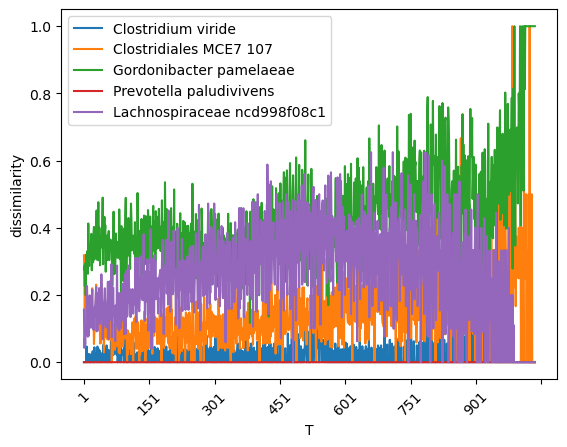

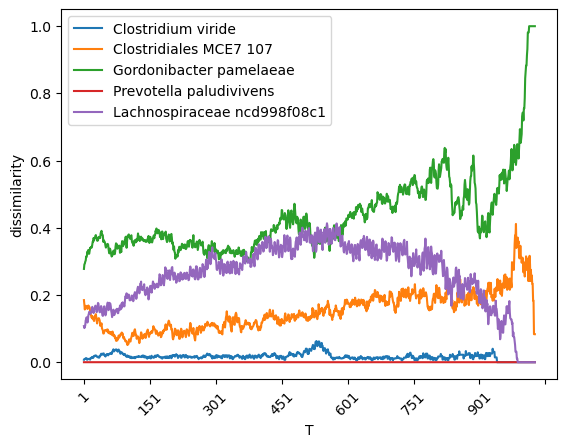

In [24]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)  
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.xlabel('T')
plt.ylabel('dissimilarity')
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.xlabel('T')
plt.ylabel('dissimilarity')
plt.legend()
plt.show()   


In [25]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
file_path = r"Inspection_Outputs\dissimilarity_1_plot.pdf"
    
if not os.path.exists(file_path):  
    plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [26]:
# Discard the initial transient (T > 10) 
mice_diss_cut=mice_diss
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss_cut[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

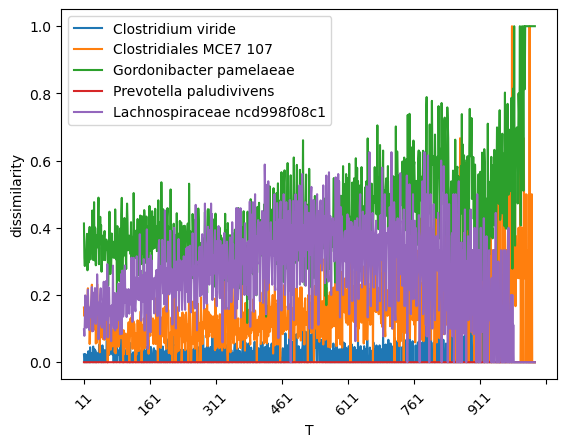

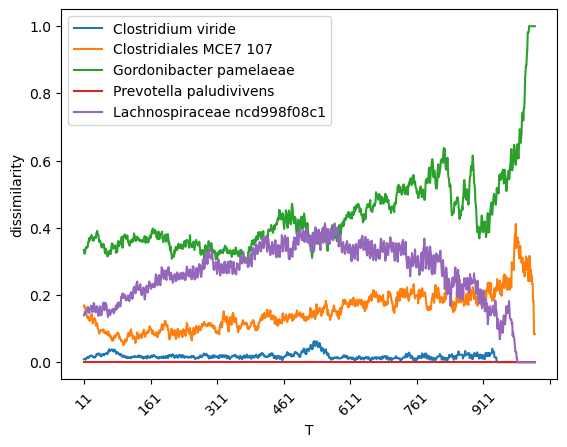

In [27]:
species = np.asarray(mice_diss_cut[0].index)
species = species[rnd_idx]
lags = np.asarray(mice_diss_cut[0].columns)

for sp in species: 
    data = mice_diss_cut[0].loc[sp].values
    lags=np.asarray(mice_diss_cut[0].columns)
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.xlabel('T')
plt.ylabel('dissimilarity')
plt.legend()
plt.show()


for sp in species: 
    data = mice_diss_cut[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.xlabel('T')
plt.ylabel('dissimilarity')
plt.legend()
plt.show()   


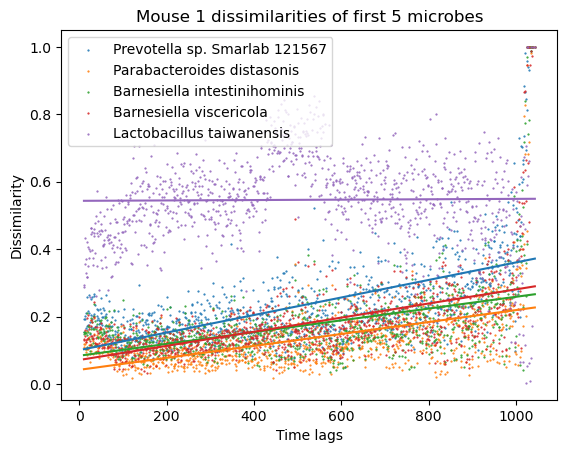

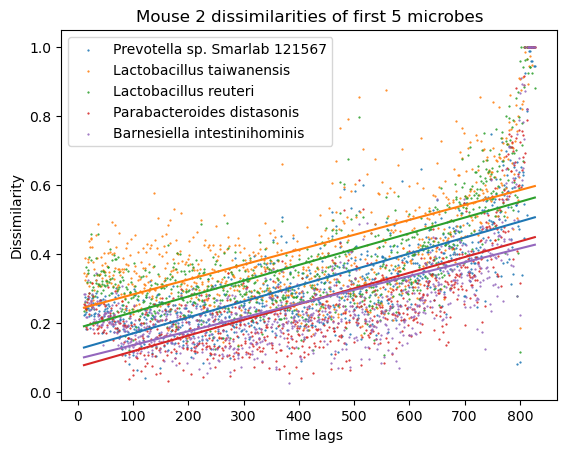

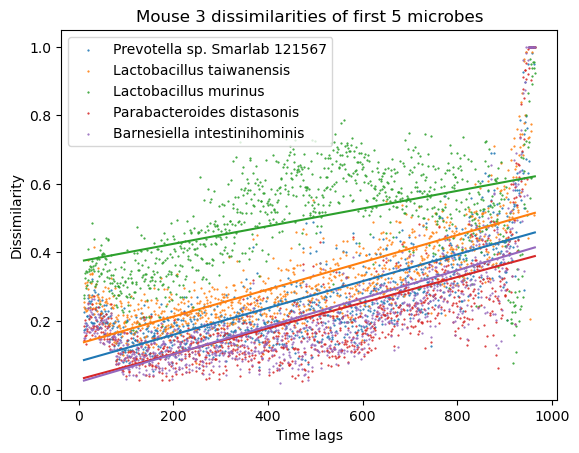

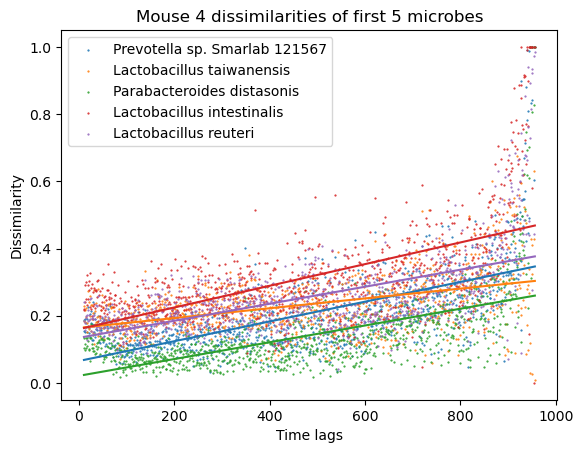

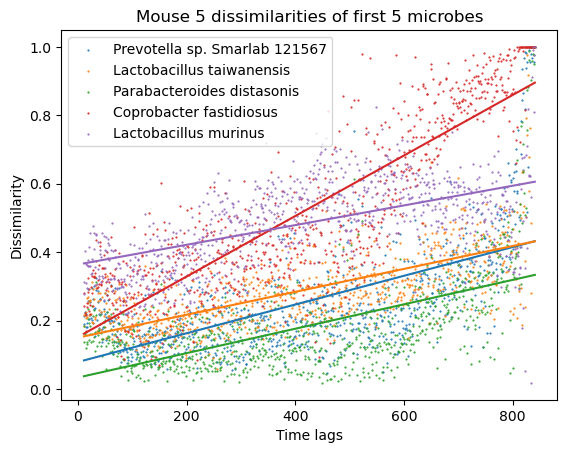

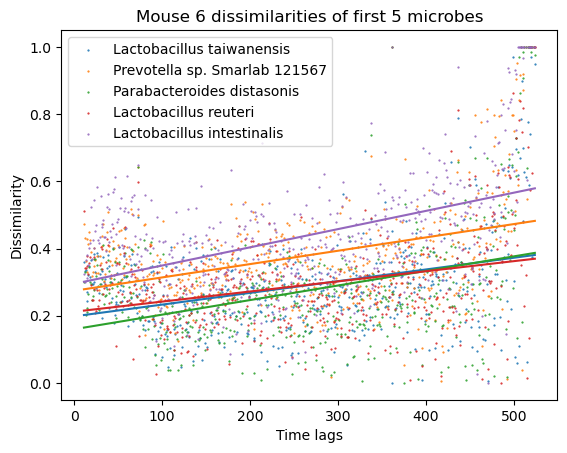

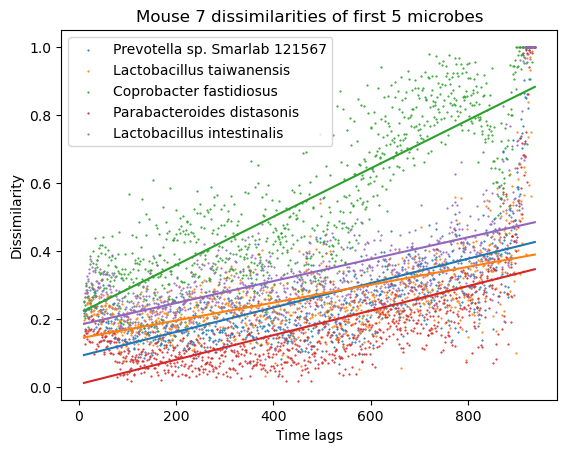

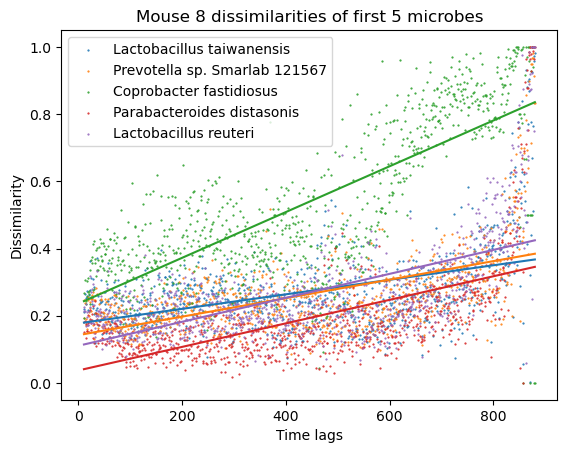

In [28]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss_cut): 
    data = mouse_df.head(5)     #why only 5?
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()
        

## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

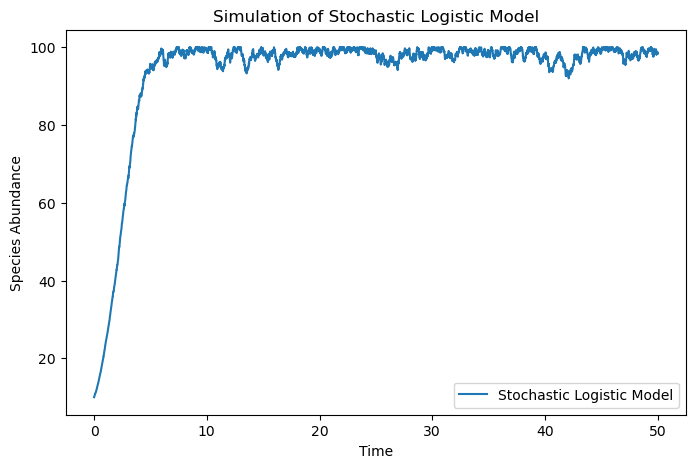

In [29]:
# Fit data of each OTU with SLM to get the parameters estimated for each OTU

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show()

In [ ]:
#FOUND A BIG ERROR!!!!! WE ARE FITTING DISSIMILARITY BUT WE NEED TO FIT ABUNDANCES
# Let's now fit this SLM simulation to our empirical time series (remember that data is stored in mice_diss, WITH TRANSIENT)
species = 'Prevotella sp. Smarlab 121567'

df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
np.asarray(df['mouse_1'])
#df.head()

array([  0,   0,   0, ...,   0,   0, 364], dtype=int64)

Estimated K: 4102.636176144317
Estimated sigma: 293.5957635387754


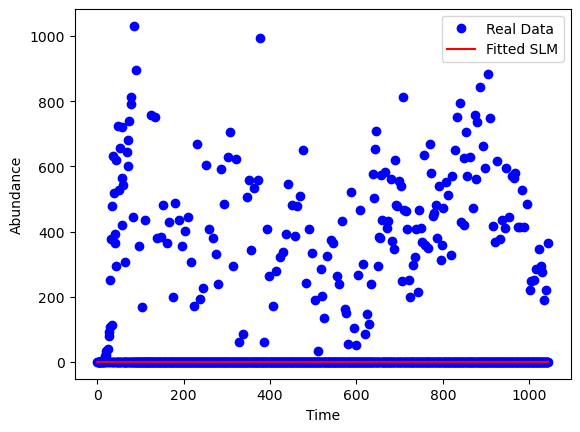

Theoretical K: 522.5484687364681
Theoretical sigma: 1.6700418256455836


In [ ]:
# Let's now fit this SLM simulation to our empirical time series (remember that data is stored in mice_diss, WITH TRANSIENT)

# Let's first try with only the first species of the first mice
df = mice_diss[0] # Get the DataFrame of the first mice
species = df.index # Get the species names 
time_series = df.loc[species[0]] # Access the data of the first specie
time_lags = np.asarray(df.columns, dtype = int) # Access the time lag values 
dt = np.asarray([time_lags[i+1] - time_lags[i] for i in range(0, len(time_lags) - 1)]) # Compute the dt
tau = 1 # Set tau = 1 following the article   WHAT IF TRYING TO ESTIMATE ALSO THIS ONE???

# Procedure (requires time_series, dt and tau)
def objective(params, time_series, dt, tau): 
    K, sigma = params
    simulated_data = simulate_SLM(ab0 = time_series.iloc[0], K = K, sigma = sigma, tau = tau, steps = len(time_series) - 1, dt = dt)
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    return np.sum((simulated_data - time_series)**2) # Minimize MSE

# Setting bounds for K and sigma
K_min = max(0.1, time_series.max() / 10)            #WE ARE DEALING WITH RELATIVE ABUNDANCE
K_max = 10 * time_series.max()
bounds_K = (K_min, K_max)
sigma_min = 1e-4  # Small but nonzero
sigma_max = 10 * time_series.std()  # Half of standard deviation
bounds_sigma = (sigma_min, sigma_max)
bounds = [bounds_K, bounds_sigma] 
result = opt.differential_evolution(objective, bounds, args=(time_series, dt, tau), strategy='best1bin') # Optimize using Differential Evolution

K_opt, sigma_opt = result.x # Extract optimal parameters
print("Estimated K:", K_opt)
print("Estimated sigma:", sigma_opt)

# Simulate data with optimal parameters
fitted_data = simulate_SLM(ab0=time_series.iloc[0], K=K_opt, sigma=sigma_opt, tau=tau, steps=len(time_lags)-1, dt=np.diff(time_lags))

# Plot real vs fitted data
plt.plot(time_lags, time_series, 'bo', label="Real Data")
plt.plot(time_lags, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.legend()
plt.show()

#estimate K, sigma using theory
var=np.var(time_series)
mean=np.mean(time_series)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

exp_diss_inf=sigma_th/(4-sigma_th)

Estimated K: 0.5000000045914783
Estimated sigma: 0.13598631411457424


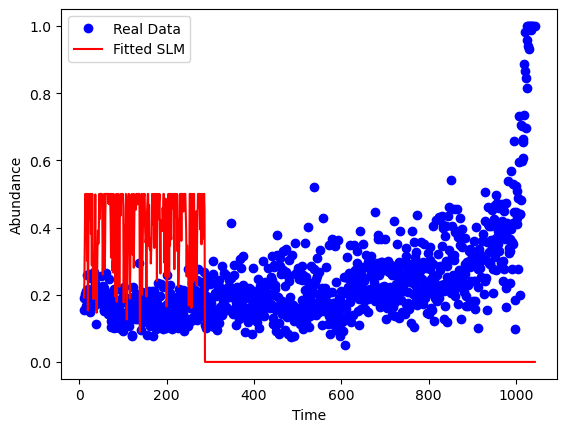

In [36]:
#TRY USING CURVE FIT ---> not good results

# Wrapper function for curve fitting
def SLM_curve_fit(t, K, sigma):
    # Simulate data using SLM
    simulated_abundance = simulate_SLM(
        ab0=time_series.iloc[0], K=K, sigma=sigma, tau=tau, steps=len(t)-1, dt=np.diff(t)
    )
    return simulated_abundance
# Initial guesses for K and sigma
K_guess = max(0.1, time_series.max()/2 )
sigma_guess = max(1e-4,  time_series.std())
# Define proper bounds
K_min, K_max = 0.01, 10 * K_guess
sigma_min, sigma_max = 1e-4, 2 * time_series.std()

popt, pcov = opt.curve_fit(SLM_curve_fit, time_lags, time_series, p0=[K_guess, sigma_guess], bounds=([K_min, sigma_min], [K_max, sigma_max]))
K_opt, sigma_opt = popt

print(f"Estimated K: {K_opt}")
print(f"Estimated sigma: {sigma_opt}")

# Simulate data with optimal parameters
fitted_data = SLM_curve_fit(time_lags, K_opt, sigma_opt)

# Plot real vs fitted data
plt.plot(time_lags, time_series, 'bo', label="Real Data")
plt.plot(time_lags, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.legend()
plt.show()



### WHAT DO YOU THINK OF THESE RESULTS? WHAT DO YOU THINK ABOUT THE IMPOSED BOUNDS? I'M NOT SO SURE AND IDK IF MAYBE WE SHOULD USE CURVE_FIT INSTEAD OF THIS
Better using differential evolution for stochastic fitting,
i have doubts about bonds: since we are dealing with relative abundancies, K min can be very low and K max can be 1, right?
for sigma bond i have no clues

i think that the fact tau=1 is too strict, maybe try to fit also this parameter?

In [38]:
#DO IT FOR EVERY MOUSE AND **STATIONARY** SPECIES   only for stationary selected species

# Store results in a dictionary
mouse_results = {}

# Loop through each mouse dataset
for mouse_idx, df in enumerate(mice_diss):      #USE DATA WITH TRANSIENT

    if mouse_idx>3:     #break after 3 different mice
        break

    species_list = df.index 
    time_lags = np.asarray(df.columns, dtype=int)  
    dt = np.diff(time_lags)  
    tau = 1  # Set tau = 1 (following the article)
    
    # Store results for this mouse
    mouse_results[mouse_idx + 1] = []

    # Loop through each species in the dataset
    for sp_idx, sp in enumerate(species_list):

        if sp_idx>10:     #break after 10 different species
            break

        time_series = df.loc[sp]  
        
        # Compute parameter bounds
        K_min = max(0.01, time_series.max() / 10)
        K_max = 10 * time_series.max()
        bounds_K = (K_min, K_max)

        sigma_min = 1e-4
        sigma_max = 2 * time_series.std()
        bounds_sigma = (sigma_min, sigma_max)

        bounds = [bounds_K, bounds_sigma]  

        # Define the objective function
        def objective(params, time_series, dt, tau):  
            K, sigma = params  
            simulated_data = simulate_SLM(
                ab0=time_series.iloc[0], K=K, sigma=sigma, tau=tau, steps=len(time_series) - 1, dt=dt
            )

            if np.isnan(simulated_data).any():  
                return np.inf  

            return np.sum((simulated_data - time_series) ** 2)  # Minimize MSE

        # Run optimization
        result = opt.differential_evolution(objective, bounds, args=(time_series, dt, tau), strategy='best1bin')

        # Store optimal parameters
        K_opt, sigma_opt = result.x
        mouse_results[mouse_idx + 1].append((sp, K_opt, sigma_opt))

    print(f"Finished processing Mouse {mouse_idx + 1}")

# Convert results to DataFrame
results_df = pd.DataFrame(
    [(mouse, sp, K, sigma) for mouse, values in mouse_results.items() for sp, K, sigma in values],
    columns=["Mouse", "Species", "K", "Sigma"]
)

# Save results for later analysis
results_df.to_csv("mice_K_sigma_results.csv", index=False)


Finished processing Mouse 1
Finished processing Mouse 2
Finished processing Mouse 3
Finished processing Mouse 4


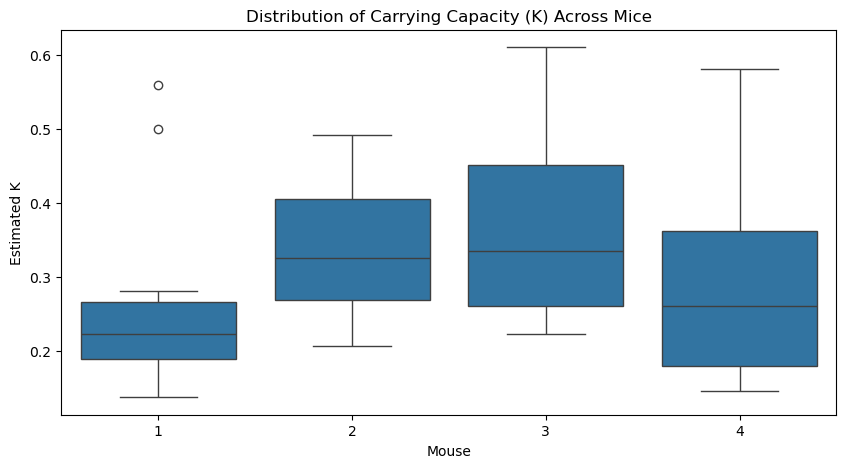

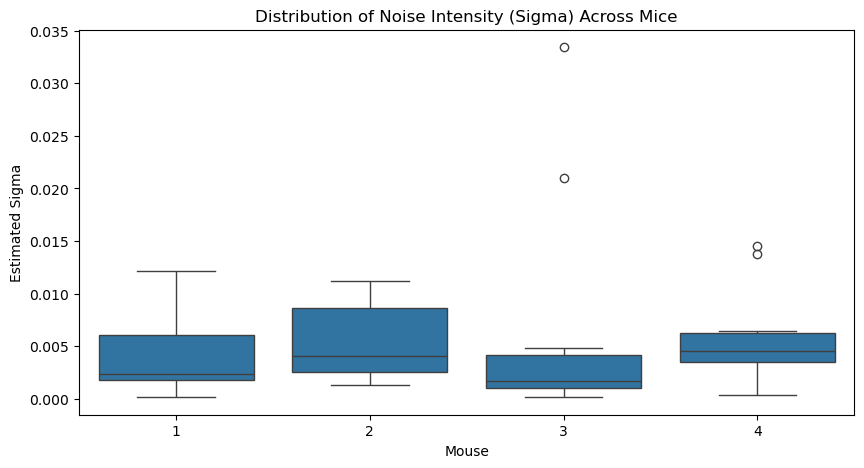

In [ ]:
# Boxplot of K across mice
plt.figure(figsize=(10, 5))
sns.boxplot(x="Mouse", y="K", data=results_df)
plt.title("Distribution of Carrying Capacity (K) Across Mice")
plt.xlabel("Mouse")
plt.ylabel("Estimated K")
plt.show()

# Boxplot of Sigma across mice
plt.figure(figsize=(10, 5))
sns.boxplot(x="Mouse", y="Sigma", data=results_df)
plt.title("Distribution of Noise Intensity (Sigma) Across Mice")
plt.xlabel("Mouse")
plt.ylabel("Estimated Sigma")
plt.show()


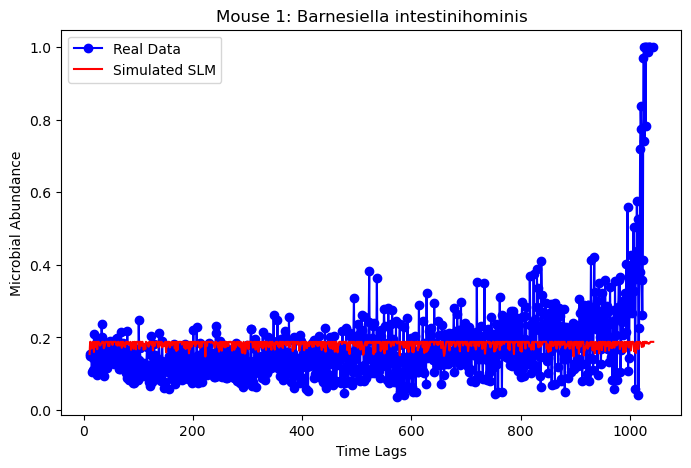

In [40]:
# Select a random species from one mouse
selected_mouse = 1  # Change this for different mice
selected_species = np.random.choice(results_df[results_df["Mouse"] == selected_mouse]["Species"])

# Get the estimated parameters
K_opt, sigma_opt = results_df[(results_df["Mouse"] == selected_mouse) & (results_df["Species"] == selected_species)][["K", "Sigma"]].values[0]

# Get real data
df = mice_diss[selected_mouse - 1]
time_series = df.loc[selected_species]
time_lags = np.asarray(df.columns, dtype=int)

# Simulate using estimated parameters
simulated_data = simulate_SLM(ab0=time_series.iloc[0], K=K_opt, sigma=sigma_opt, tau=tau, steps=len(time_series) - 1, dt=np.diff(time_lags))

# Plot real vs simulated
plt.figure(figsize=(8, 5))
plt.plot(time_lags, time_series, 'bo-', label="Real Data")
plt.plot(time_lags, simulated_data, 'r-', label="Simulated SLM")
plt.xlabel("Time Lags")
plt.ylabel("Microbial Abundance")
plt.title(f"Mouse {selected_mouse}: {selected_species}")
plt.legend()
plt.show()


In [ ]:
# Sample counts for days for which the individual was sampled

In [ ]:
# Compute the dissimilarity for the simulated data 

In [ ]:
# Compute the slope obtained for the dissimilarity of simulated data

In [ ]:
# Compute the treshold for each individual as the 95% quantile of the slopes obtained for that individual

## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

- if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

- calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.
